# Validate a tool against IDR data: Load Image with labels from IDR, re-analyze using Cellpose

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/EMBL-EBI-imaging-course-05-2023/blob/main/Day_4/Cellpose.ipynb)

## Learning Objectives


* How to access public resource via the [Python API](https://omero-guides.readthedocs.io/en/latest/python/docs/index.html).
* How to load image data.
* How to load Regions of Interest (ROIs) associated to an image.
* Compare ROIs submitted by the authors and the ones generated using CellPose to validate the model used.

## Summary:
![Overview](./includes/CellposeIDR.png)

A set of walkthroughs showing the [exploration of IDR via the User Interface](Exploring_IDR_UI.ipynb) is available in both text and video versions. These walkthroughs show the publication mentioned below and images from it in a larger context inside IDR and how it is linked to external resources.

IDR is based on [OMERO](https://www.openmicroscopy.org/omero/) and thus all what we show in this notebook can be easily adjusted for use against another OMERO server, e.g. your institutional OMERO server instance.

The main objective of this notebook is to demonstrate how public resources such as the IDR can be used to train your neural network or validate software tools.

The authors of the PLOS Biology paper, "Nessys: A new set of tools for the automated detection of nuclei within intact tissues and dense 3D cultures" published in August 2019: https://doi.org/10.1371/journal.pbio.3000388, considered several image segmenation packages, but they did not use the approach described in this notebook.

We will analyse the data using [Cellpose](https://www.cellpose.org/) and compare the output with the original segmentation produced by the authors. StarDist was not considered by the authors. Our workflow shows how public repository can be accessed and data inside it used to validate software tools or new algorithms.

We will use an image (``id=6001247``) referenced in the paper. The image can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=image-6001247) (IDR).


We will use a predefined model from [Cellpose](https://www.cellpose.org/) as a starting point. Steps to access data from IDR could be re-used if you wish to create a new model (outside the scope of this notebook).

## Launch

This notebook uses the [environment_cellpose.yml](./environment_cellpose.yml) file.

See [Setup](./workshop.ipynb).

### Install dependencies if required

The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). Running the cell could take some time due to the installation of one the dependencies required by ``omero-py``. **Do not run the cell if you are not running the notebook on Google Colab**.

In [1]:
# Package required to interact with Cellpose
%pip install cellpose==2.2.1

# Package required to interact with IDR or OMERO
%pip install omero-py==5.13.1

# Package to convert masks stored in OMERO/IDR into numpy arrays
%pip install omero-cli-zarr==0.5.2

## First connect to IDR

This is the first step to any action when using the Python API.

In [1]:
from omero.gateway import BlitzGateway
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


In [2]:
image_id = 6001247

## Load an image

We load information about the image but **not** the binary data. An image is a 5D-object (XYZCT).

In [3]:
image = conn.getObject("Image", image_id)
print(image.getName())

B4_C3.tif


In [4]:
print("Size X: %s, Size Y: %s" % (image.getSizeX(), image.getSizeY()))

Size X: 253, Size Y: 210


## Load the binary data

To access the binary data, we need to load the `pixels` object from the image and retrieve the plane(s).

When using the API, you can selectively load only the planes you need for your analysis. This is an advantage when using analytical tools requiring planar data, e.g. CellProfiler.

In [5]:
import numpy

def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_x = image.getSizeX()
    size_y = image.getSizeY()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "t:%s c:%s z:%s" % (size_t, size_c, size_z)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_c, size_z, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

## Load the 5D array

We load the binary data as 5D numpy array.

In [6]:
data = load_numpy_array(image)

In [7]:
print(data.shape)

(1, 2, 257, 210, 253)


## Load Cellpose trained model 

We use an existing trained model from Cellpose. The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel. 
Please check Cellpose documentation and examples to load your own model.

In [8]:
from cellpose import models
model = models.Cellpose(gpu=False, model_type='cyto')

In [9]:
channels = [[0, 1]]
t = 0
z = int(image.getPrimaryPixels().getSizeZ() / 2)
cellpose_masks, flows, styles, diams = model.eval(data[t, :, z, :, :], diameter=None, channels=channels)

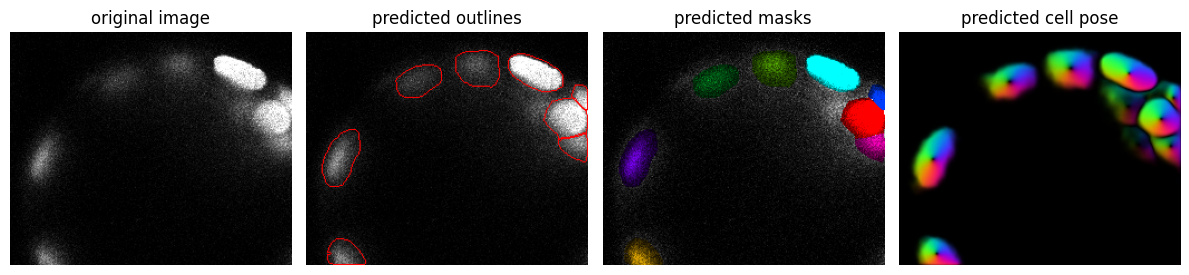

In [10]:
from cellpose import plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, data[t, 1, z, :, :], cellpose_masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

## Load the ROIs from IDR

Original labels have been saved as mask ROIs in IDR. Load the original labels in order to compare them with the Cellpose ones.

In [11]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(image_id, None)

shapes = []
for roi in result.rois:
    shapes.append(roi.copyShapes())

To compare the labels, we need to convert the masks into a NumPy array.

In [12]:
from omero_zarr import masks
dims = (image.getSizeT(), image.getSizeC(), image.getSizeZ(), image.getSizeY(), image.getSizeX())
saver = masks.MaskSaver(None, image, numpy.int64)
labels, fillColors, properties = saver.masks_to_labels(shapes, mask_shape=dims)

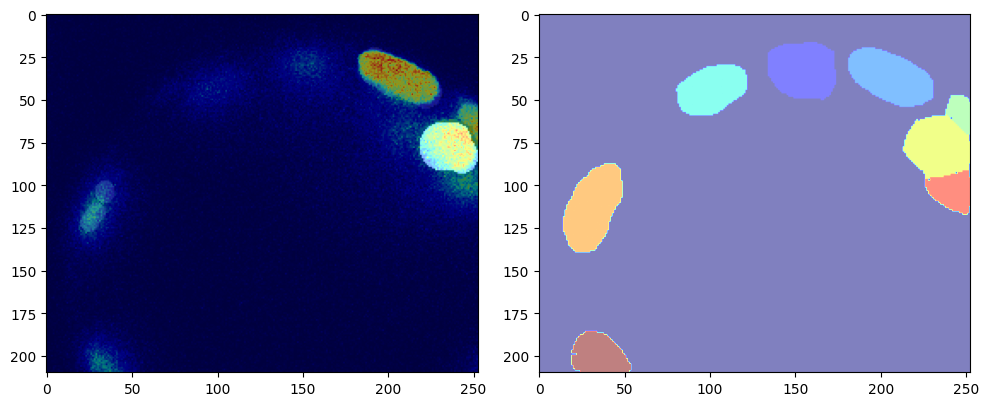

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
c = 1
t = 0
fig = plt.figure(figsize=(10, 10))
# Show the original labels from IDR
sub1 = plt.subplot(121)
sub1.title.set_text('Original labels IDR')
plt.imshow(labels[t, c, z, :, :], cmap='gray', alpha=0.5)
# Show the Cellpose labels
sub2 = plt.subplot(122)
sub2.title.set_text('Cellpose labels this notebook')
plt.imshow(cellpose_masks, cmap='jet', alpha=0.5)
fig2 = plt.figure(figsize=(8.5, 8.5))
# Show the original image
sub3 = plt.subplot(121)
sub3.title.set_text("Original unsegmented image")
plt.imshow(data[t, c, z, :, :], cmap='jet')
# Show the Cellpose labels
sub4 = plt.subplot(122)
sub4.title.set_text('Cellpose labels this notebook')
plt.imshow(cellpose_masks, cmap='jet', alpha=0.5)
plt.tight_layout()
fig.canvas.flush_events()

## Save the Cellpose outlines

Convert the Cellpose outlines into OME ROI.

In [11]:
from cellpose import io, utils
outlines = utils.outlines_list(cellpose_masks)
io.outlines_to_text(str(image_id), outlines)

In [13]:
def create_roi(img, shapes):
    # create an ROI, link it to Image
    roi = omero.model.RoiI()
    # use the omero.model.ImageI that underlies the 'image' wrapper
    roi.setImage(img._obj)
    for shape in shapes:
        roi.addShape(shape)
    return roi

In [14]:
# Convert roi into ome rois
import re
import omero
from omero.rtypes import rdouble, rint, rstring
polygons = []
with open(str(image_id) + "_cp_outlines.txt", "r") as text_file:
    for line in text_file:
        points = re.sub(r',([^,]*),', r',\1, ', line)
        polygon = omero.model.PolygonI()
        polygon.theZ = rint(z)
        polygon.theT = rint(t)
        polygon.points = rstring(points)
        polygons.append(polygon)
roi = create_roi(image, polygons)

### Save the ROI
This cannot be saved to IDR since it is a Read-only server.

In [16]:
# Save the ROI when using an OMERO server
if "idr" not in HOST:
    conn.getUpdateService().saveAndReturnObject(roi)

## Close the connection

In [17]:
def disconnect(conn):
    """
    Disconnect from an OMERO server
    :param conn: The BlitzGateway
    """
    conn.close()

disconnect(conn)

### License (BSD 2-Clause)¶

Copyright (C) 2023 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.